In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

from src.evaluate import calculate_class_accuracies, calculate_r2_scores
from src.rf import run_forest_class

train_features = pd.read_csv('./data/derived/feature_selection/training_data.csv', index_col=0)
test_features = pd.read_csv('./data/derived/feature_selection/test_data.csv', index_col=0)

# 1 - EDA

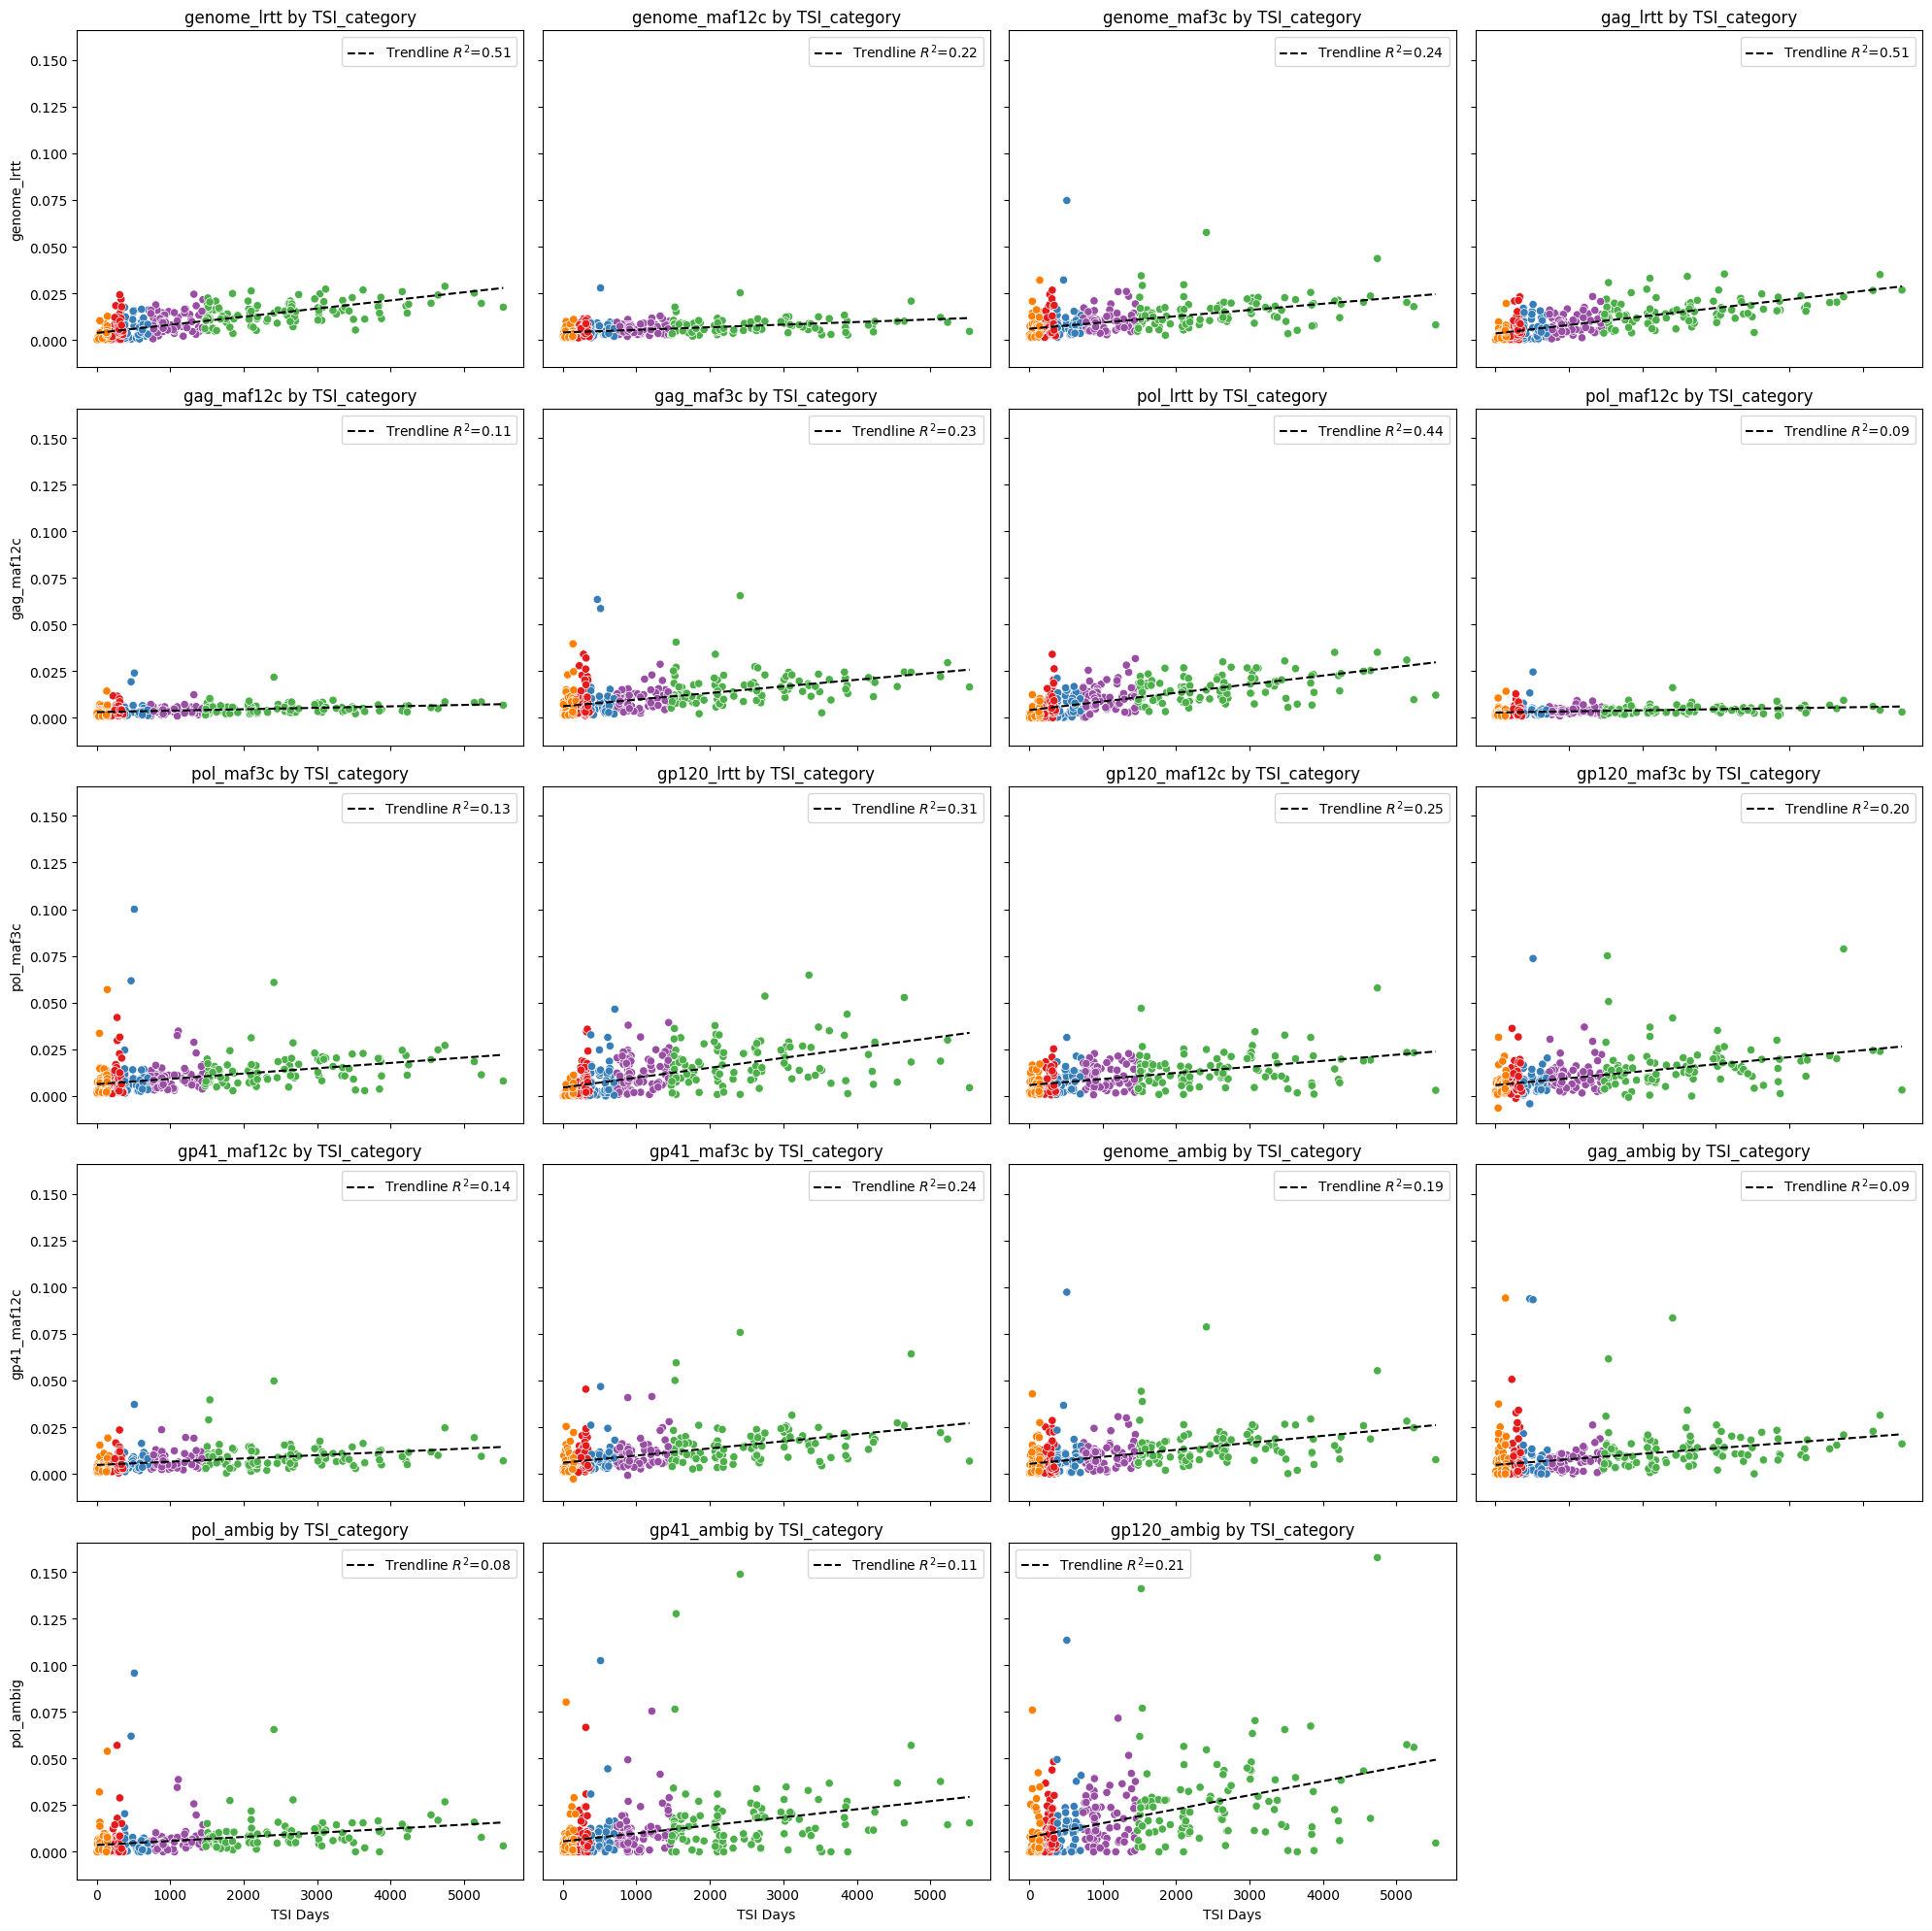

In [27]:
# List of features
features = [
    'genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 
    'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 
    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 
    'gp41_maf12c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 
    'gp120_ambig'
]

# Dictionary to store R² values
r2_values = {}

# Calculate R² values for each feature within each TSI category
for feature in features:
    r2_values[feature] = {}
    for category in train_features['TSI_category'].unique():
        subset = train_features[train_features['TSI_category'] == category]
        if len(subset) > 1:  # Ensure there are enough data points
            X = subset[['TSI_days']]
            y = subset[feature]
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            r2_values[feature][category] = r2
        else:
            r2_values[feature][category] = np.nan

# Plot features with R² values in titles
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    ax = axes[i]
    sns.scatterplot(ax=ax, data=train_features, x='TSI_days', y=feature, hue='TSI_category', palette='Set1', legend=False)
    ax.set_title(f'{feature} by TSI_category')
    ax.set_xlabel('TSI Days')
    ax.set_ylabel(feature)
    
    # Fit a linear regression model for the entire dataset
    subset = train_features.dropna(subset=[feature, 'TSI_days'])
    X = subset[['TSI_days']]
    y = subset[feature]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Add trendline
    sns.lineplot(ax=ax, x='TSI_days', y=y_pred, data=subset, color='black', label=f'Trendline $R^2$={r2:.2f}', linestyle='--')
    
    ax.legend()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('./outputs/features/tsi_corr.png')
plt.show()

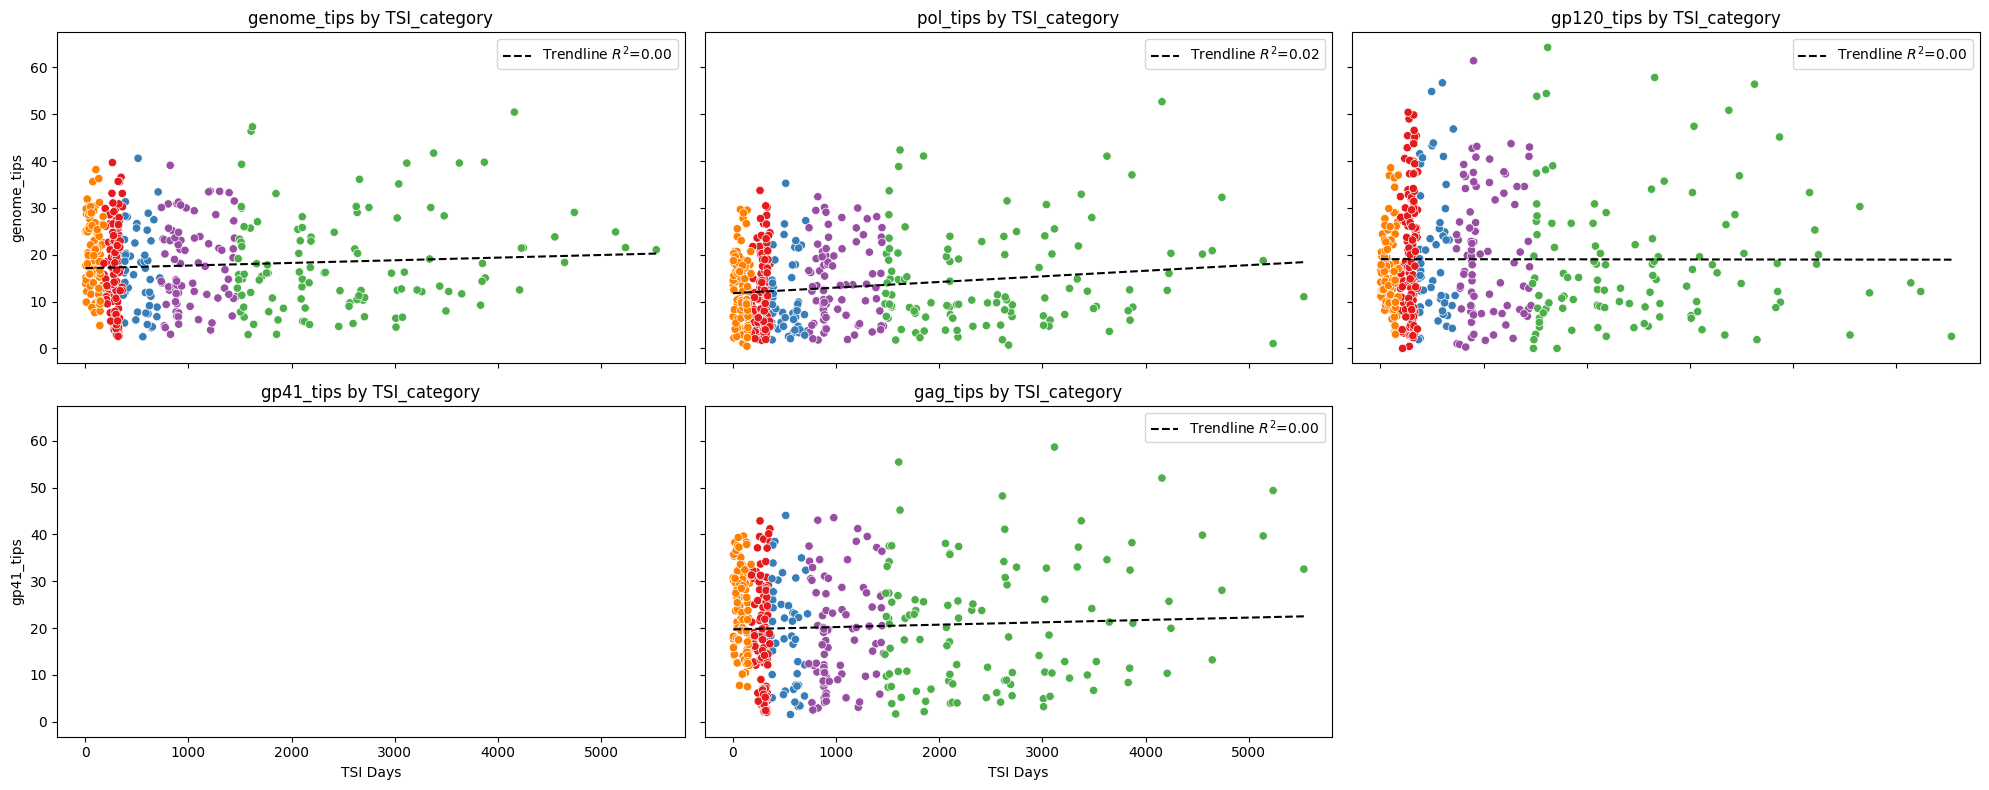

In [26]:
features_tips = ['genome_tips', 'pol_tips', 'gp120_tips', 'gp41_tips', 'gag_tips']
n_cols = 3
n_rows = int(np.ceil(len(features_tips) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, feature in enumerate(features_tips):
    ax = axes[i]
    sns.scatterplot(ax=ax, data=train_features, x='TSI_days', y=feature, hue='TSI_category', palette='Set1', legend=False)
    ax.set_title(f'{feature} by TSI_category')
    ax.set_xlabel('TSI Days')
    ax.set_ylabel(feature)
    
    # Fit a linear regression model
    subset = train_features.dropna(subset=[feature, 'TSI_days'])
    if len(subset) > 1:  # Ensure there are enough data points
        X = subset[['TSI_days']]
        y = subset[feature]
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        sns.lineplot(ax=ax, x='TSI_days', y=y_pred, data=subset, color='black', label=f'Trendline $R^2$={r2:.2f}', linestyle='--') #trendline
        
        ax.legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('./outputs/features/tips_corr.png')
plt.show()

# 2 - CLASSIFIER WITH DIFF FEATURE SETS

In [39]:
#DEFINE FEATURE SETS 
predictor_sets = {
    'Alex':    ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips" ,"gp41_maf12c","gp41_maf3c", 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Genome':  ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig'],
    'ENV':     ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig'],
    'GAG_ENV': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gp120_ambig'],
    'All':     ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_tips',
                'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Genome_ENV_GAG': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'], 
    'Andrea':  ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c','gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Optimal': ['genome_lrtt','genome_tips','gag_lrtt','gag_tips','pol_lrtt','pol_tips',
                'gp120_lrtt', 'gp120_tips', 'genome_maf12c', 'genome_maf3c', 'gag_maf12c',
                'gag_maf3c', 'pol_maf12c', 'pol_maf3c' ,'gp120_maf12c' ,'gp120_maf3c',
                'gp41_maf12c' ,'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig',
                'gp120_ambig']}

# DEFINE X AND Y 
X_train = train_features.drop(columns=['TSI_category'])
y_train = train_features['TSI_category']
X_test = test_features.drop(columns=['TSI_category'])
y_test = test_features['TSI_category']

#RUN RANDOM FOREST CLASSIFIER FOR EACH PREDICTOR SET 
results = []
for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

    Predictor Set  Accuracy
6          Andrea  0.580645
0            Alex  0.554839
4             All  0.554839
7         Optimal  0.548387
5  Genome_ENV_GAG  0.541935
3         GAG_ENV  0.522581
1          Genome  0.516129
2             ENV  0.438710


# CLASS ACCURACIES AND R2 SCORE 

In [40]:
predictor_sets = {
    'Alex':           ["gag_lrtt", "gag_tips", "gag_maf3c", 
                        "pol_lrtt", 
                        "gp120_lrtt", "gp120_tips", 
                        "gp41_tips" ,"gp41_maf12c", "gp41_maf3c"],
    'Genome':         ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips'],
    'ENV':            ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'],
    'GAG_ENV':        ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                       'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips'],
    'All':            ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                        'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 
                        'pol_lrtt', 'pol_tips', 'pol_maf12c', 'pol_maf3c', 
                        'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 
                        'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c'],
    'Genome_ENV_GAG': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                       'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 
                       'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'], 
    'Andrea':          ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c',
                        'gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 
                        'gp41_maf3c']}


In [41]:
# Encode the TSI_category
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
train_features['TSI_encoded'] = ordinal_encoder.fit_transform(train_features[['TSI_category']])
test_features['TSI_encoded'] = ordinal_encoder.fit_transform(test_features[['TSI_category']])

#NUMBER OF CV FOLDS
min_class_size = train_features['TSI_encoded'].value_counts().min()
n_splits = min(10, min_class_size) 
print(n_splits)

10


In [45]:
accuracy_results = {}
r2_results = {}

for set_name, predictors in predictor_sets.items():
    class_accuracies_mean, class_accuracies_ci = calculate_class_accuracies(train_features, predictors)
    accuracy_results[set_name] = {
        'class_accuracies_mean': class_accuracies_mean,
        'class_accuracies_ci': class_accuracies_ci
    }
    
    mean_r2, r2_ci = calculate_r2_scores(train_features, predictors)
    r2_results[set_name] = {
        'mean_r2': mean_r2,
        'r2_ci': r2_ci
    }

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


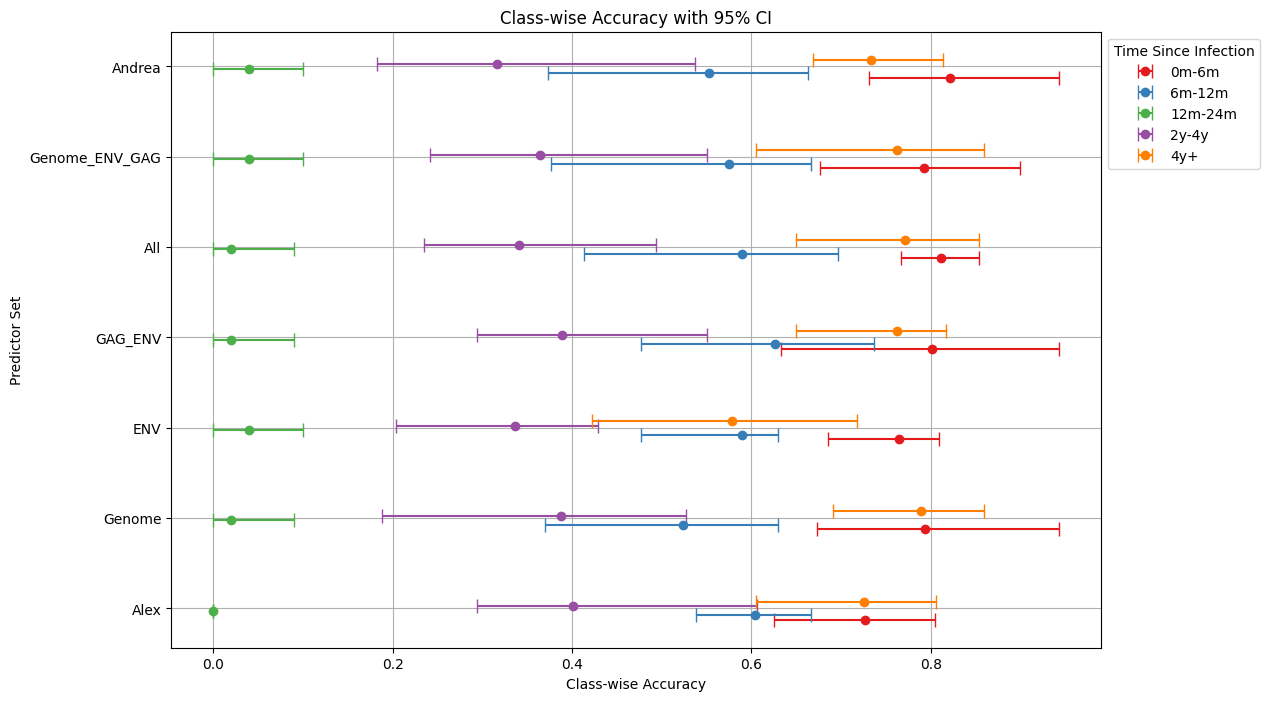

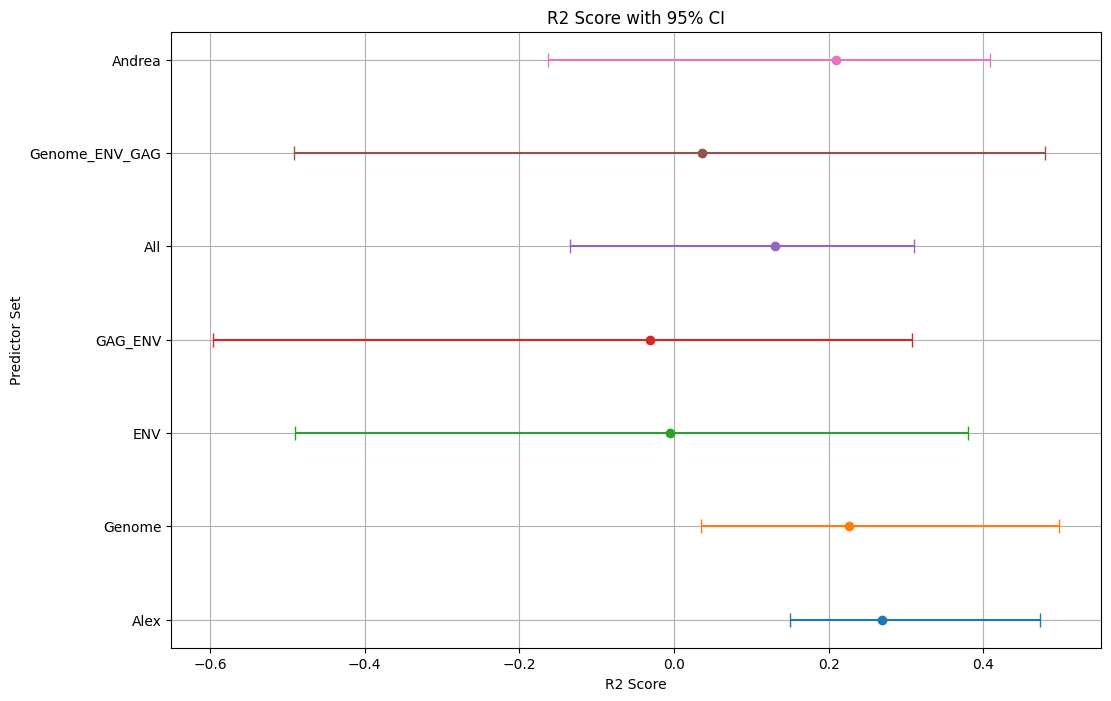

In [46]:
category_names = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']

plot_data = []
for set_name, result in accuracy_results.items():
    class_accuracies_mean = result['class_accuracies_mean']
    class_accuracies_ci = result['class_accuracies_ci']
    
    for label, mean in class_accuracies_mean.items():
        ci = class_accuracies_ci[label]
        plot_data.append({
            'Predictor Set': set_name,
            'Class': label,
            'Mean Accuracy': mean,
            'CI Lower': ci[0],
            'CI Upper': ci[1]
        })

plot_df = pd.DataFrame(plot_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each class
colors = sns.color_palette("Set1", len(plot_df['Class'].unique()))

# Define a fixed shift for each class
class_shift = 0.05
classes = plot_df['Class'].unique()

# Plot class-wise accuracies with fixed shift
for i, set_name in enumerate(plot_df['Predictor Set'].unique()):
    subset = plot_df[plot_df['Predictor Set'] == set_name]
    for j, (class_label, class_subset) in enumerate(subset.groupby('Class')):
        shift = (j - len(classes) / 2) * class_shift  # Shift each class by a fixed amount
        ax.errorbar(class_subset['Mean Accuracy'], i + shift, 
                    xerr=[class_subset['Mean Accuracy'] - class_subset['CI Lower'], class_subset['CI Upper'] - class_subset['Mean Accuracy']], 
                    fmt='o', capsize=5, color=colors[j], label=f'{category_names[int(class_label)]}' if i == 0 else "")
    
ax.set_xlabel('Class-wise Accuracy')
ax.set_ylabel('Predictor Set')
ax.set_title('Class-wise Accuracy with 95% CI')
ax.legend(title='Time Since Infection', bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_yticks(np.arange(len(plot_df['Predictor Set'].unique())))
ax.set_yticklabels(plot_df['Predictor Set'].unique())
ax.grid(True)
plt.savefig('./outputs/classifier/class_accuracy.png')
plt.show()

'''# Plot R2 results with fixed shift
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i, (set_name, result) in enumerate(r2_results.items()):
    mean_r2 = result['mean_r2']
    r2_ci = result['r2_ci']
    ax.errorbar(mean_r2, i, xerr=[[mean_r2 - r2_ci[0]], [r2_ci[1] - mean_r2]], fmt='o', capsize=5, label=set_name)

ax.set_xlabel('R2 Score')
ax.set_ylabel('Predictor Set')
ax.set_title('R2 Score with 95% CI')
ax.set_yticks(np.arange(len(r2_results)))
ax.set_yticklabels(r2_results.keys())
ax.grid(True)
plt.show()'''